/tmp/ipython-input-1821955974.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Cumulative Asset Return: 2.1711436734980736
Cumulative Strategy Return: -0.25488062999679395


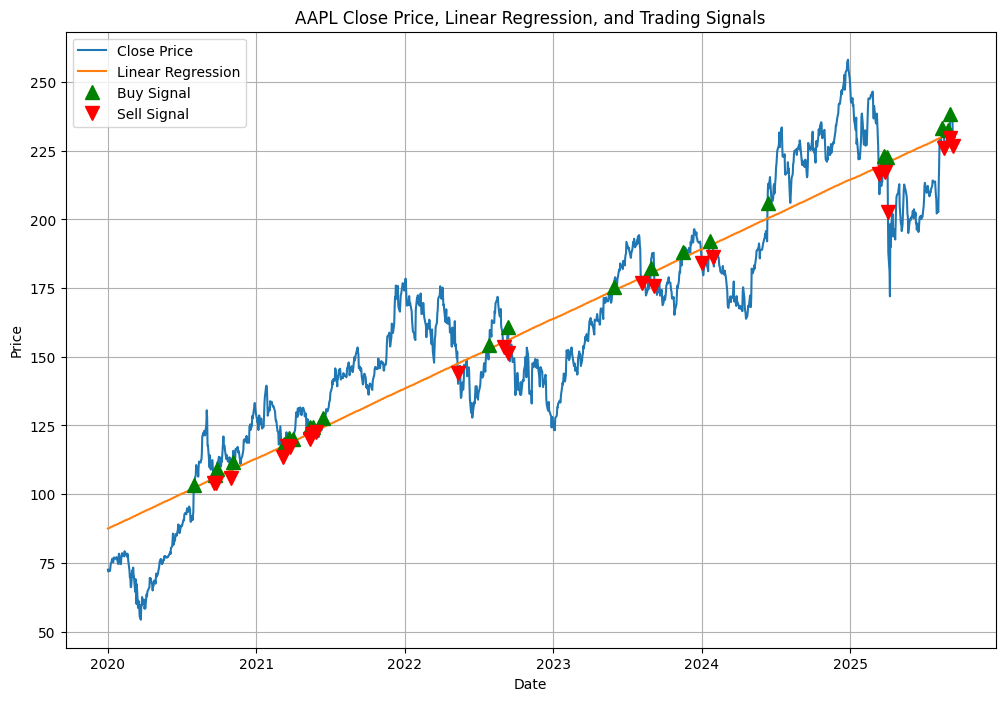

Price,Close,High,Low,Open,Volume,Trading_Day,Linear_Regression,Signal,Position,Daily_Return,Strategy_Return,Cumulative_Asset_Return,Cumulative_Strategy_Return,MA_50,MA_200
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2025-09-05,239.690002,241.320007,238.490005,240.000000,54870400,1426,231.532115,0,1,-0.000375,-0.000375,2.304314,-0.212498,218.265623,220.919662
2025-09-08,237.880005,240.149994,236.339996,239.300003,48999500,1427,231.633109,0,1,-0.007551,-0.007551,2.279362,-0.218444,219.007781,220.988042
2025-09-09,234.350006,238.779999,233.360001,237.000000,66313900,1428,231.734103,0,1,-0.014839,-0.014839,2.230698,-0.230042,219.677740,221.023725
2025-09-10,226.789993,232.419998,225.949997,232.190002,83440800,1429,231.835097,-1,0,-0.032259,-0.032259,2.126478,-0.254881,220.114792,221.020312
2025-09-11,230.029999,230.449997,226.649994,226.880005,50150900,1430,231.936091,0,0,0.014286,0.000000,2.171144,-0.254881,220.563703,221.029512


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fetch financial data
ticker_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')
aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate linear regression
aapl_data['Trading_Day'] = np.arange(len(aapl_data))
X = aapl_data['Trading_Day'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, aapl_data['Close'])
aapl_data['Linear_Regression'] = model.predict(X)

# Implement trading logic with threshold
aapl_data['Signal'] = 0
position = 0
threshold = 0.005  # 0.5% threshold

for i in range(1, len(aapl_data)):
    current_close = aapl_data['Close'].iloc[i].item()
    previous_close = aapl_data['Close'].iloc[i-1].item()
    current_lr = aapl_data['Linear_Regression'].iloc[i].item()
    previous_lr = aapl_data['Linear_Regression'].iloc[i-1].item()

    # Buy signal with threshold
    if current_close > current_lr * (1 + threshold) and previous_close <= previous_lr * (1 + threshold) and position == 0:
        aapl_data.loc[aapl_data.index[i], 'Signal'] = 1
        position = 1

    # Sell signal with threshold
    elif current_close < current_lr * (1 - threshold) and previous_close >= previous_lr * (1 - threshold) and position == 1:
        aapl_data.loc[aapl_data.index[i], 'Signal'] = -1
        position = 0

# Backtest the strategy
aapl_data['Position'] = 0
for i in range(1, len(aapl_data)):
    if aapl_data['Signal'].iloc[i] == 1 and aapl_data['Position'].iloc[i-1] == 0:
        aapl_data.loc[aapl_data.index[i], 'Position'] = 1
    elif aapl_data['Signal'].iloc[i] == -1 and aapl_data['Position'].iloc[i-1] == 1:
        aapl_data.loc[aapl_data.index[i], 'Position'] = 0
    else:
        aapl_data.loc[aapl_data.index[i], 'Position'] = aapl_data['Position'].iloc[i-1]

aapl_data['Daily_Return'] = aapl_data['Close'].pct_change()
aapl_data['Strategy_Return'] = aapl_data['Daily_Return'] * aapl_data['Position'].shift(1)
aapl_data['Cumulative_Asset_Return'] = (1 + aapl_data['Daily_Return']).cumprod() - 1
aapl_data['Cumulative_Strategy_Return'] = (1 + aapl_data['Strategy_Return'].fillna(0)).cumprod() - 1 # Fill NaN for cumulative product

# Calculate Moving Averages
aapl_data['MA_50'] = aapl_data['Close'].rolling(window=50).mean()
aapl_data['MA_200'] = aapl_data['Close'].rolling(window=200).mean()


# Display results
print("Cumulative Asset Return:", aapl_data['Cumulative_Asset_Return'].iloc[-1])
print("Cumulative Strategy Return:", aapl_data['Cumulative_Strategy_Return'].iloc[-1])

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(aapl_data.index, aapl_data['Close'], label='Close Price')
plt.plot(aapl_data.index, aapl_data['Linear_Regression'], label='Linear Regression')
plt.plot(aapl_data.loc[aapl_data['Signal'] == 1].index,
         aapl_data['Close'][aapl_data['Signal'] == 1],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(aapl_data.loc[aapl_data['Signal'] == -1].index,
         aapl_data['Close'][aapl_data['Signal'] == -1],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('AAPL Close Price, Linear Regression, and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

display(aapl_data.tail())